In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random
np.random.seed(1234)
random.seed(1234)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb

In [2]:
train_df=pd.read_csv('/content/drive/MyDrive/house_price/data/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/house_price/data/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/house_price/data/sample_submission.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [5]:
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [6]:
for cat in categories:
  le=LabelEncoder()
  print(cat)
  all_df[cat].fillna('missing',inplace=True)
  le=le.fit(all_df[cat])
  all_df[cat]=le.transform(all_df[cat])
  all_df[cat]=all_df[cat].astype('category')

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [7]:
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]

In [8]:
from sklearn.model_selection import KFold
folds=3
kf=KFold(n_splits=folds)

In [9]:
lgbm_params={
    'objective':'regression',
    'random_seed':1234
}

In [10]:
train_X=train_df_le.drop(['SalePrice','Id'],axis=1)
train_Y=train_df_le['SalePrice']

In [11]:
models=[]
rmses=[]
oof=np.zeros(len(train_X))
for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_valid=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_valid=train_Y.iloc[val_index]

  lgb_train=lgb.Dataset(X_train,y_train)
  lgb_eval=lgb.Dataset(X_valid,y_valid,reference=lgb_train)

  model_lgb=lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      num_boost_round=100,
                      early_stopping_rounds=20,
                      verbose_eval=10,)
  y_pred=model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
  tmp_rmse=np.sqrt(mean_squared_error(np.log(y_valid),np.log(y_pred)))
  print(tmp_rmse)

  models.append(model_lgb)
  rmses.append(tmp_rmse)
  oof[val_index]=y_pred

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 1.59541e+09
[20]	valid_0's l2: 7.467e+08
[30]	valid_0's l2: 5.96558e+08
[40]	valid_0's l2: 5.49479e+08
[50]	valid_0's l2: 5.29299e+08
[60]	valid_0's l2: 5.28785e+08
[70]	valid_0's l2: 5.32577e+08
Early stopping, best iteration is:
[57]	valid_0's l2: 5.26368e+08
0.12637668452645173


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 2.08125e+09
[20]	valid_0's l2: 1.23117e+09
[30]	valid_0's l2: 1.04155e+09
[40]	valid_0's l2: 9.92123e+08
[50]	valid_0's l2: 9.69222e+08
[60]	valid_0's l2: 9.54807e+08
[70]	valid_0's l2: 9.50536e+08
[80]	valid_0's l2: 9.45353e+08
[90]	valid_0's l2: 9.40359e+08
[100]	valid_0's l2: 9.36486e+08
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 9.36066e+08
0.15229205843857013


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 1.78839e+09
[20]	valid_0's l2: 1.03494e+09
[30]	valid_0's l2: 8.77181e+08
[40]	valid_0's l2: 8.59747e+08
[50]	valid_0's l2: 8.45919e+08
[60]	valid_0's l2: 8.35019e+08
[70]	valid_0's l2: 8.27851e+08
[80]	valid_0's l2: 8.37089e+08
Early stopping, best iteration is:
[69]	valid_0's l2: 8.26998e+08
0.13226664456356535


In [12]:
sum(rmses)/len(rmses)

0.13697846250952908

In [13]:
from statistics import  mean
mean(rmses)

0.13697846250952908

In [14]:
actual_pred_df=pd.DataFrame({
                              'actual':train_Y,
                              'pred':oof
})

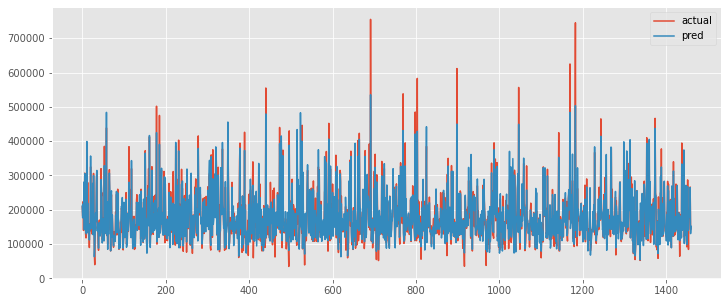

In [15]:
actual_pred_df.plot(figsize=(12,5))

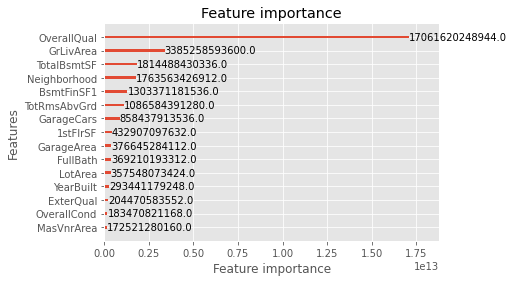

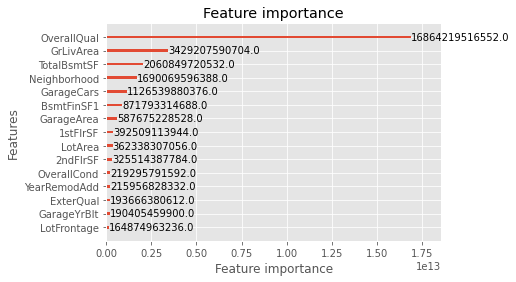

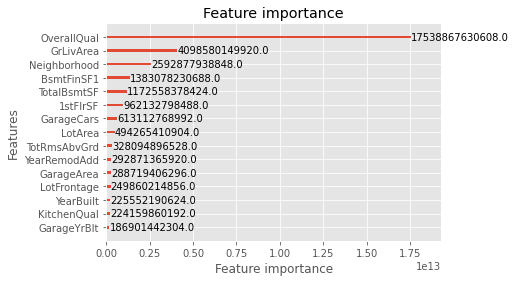

In [16]:
for model in models:
  lgb.plot_importance(model,importance_type='gain',max_num_features=15)

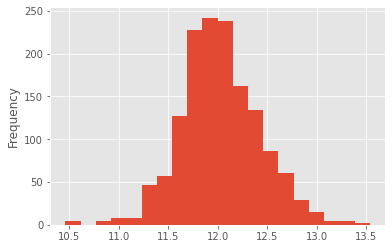

In [17]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [18]:
train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

In [20]:
models=[]
rmses=[]
oof=np.zeros(len(train_X))
for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_valid=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_valid=train_Y.iloc[val_index]

  lgb_train=lgb.Dataset(X_train,y_train)
  lgb_eval=lgb.Dataset(X_valid,y_valid,reference=lgb_train)

  model_lgb=lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      num_boost_round=100,
                      early_stopping_rounds=20,
                      verbose_eval=10,)
  y_pred=model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
  tmp_rmse=np.sqrt(mean_squared_error(y_valid,y_pred))
  print(tmp_rmse)

  models.append(model_lgb)
  rmses.append(tmp_rmse)
  oof[val_index]=y_pred

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.0435757
[20]	valid_0's l2: 0.0223987
[30]	valid_0's l2: 0.0176962
[40]	valid_0's l2: 0.0164304
[50]	valid_0's l2: 0.0161943
[60]	valid_0's l2: 0.0161858
[70]	valid_0's l2: 0.0161666
[80]	valid_0's l2: 0.0161769
[90]	valid_0's l2: 0.0162121
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0161129
0.12693572281592597


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.0480056
[20]	valid_0's l2: 0.0274907
[30]	valid_0's l2: 0.022779
[40]	valid_0's l2: 0.0214744
[50]	valid_0's l2: 0.0209095
[60]	valid_0's l2: 0.0205922
[70]	valid_0's l2: 0.0204381
[80]	valid_0's l2: 0.0203135
[90]	valid_0's l2: 0.020318
[100]	valid_0's l2: 0.0202246
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0202246
0.1422133338842566


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.0388654
[20]	valid_0's l2: 0.0209198
[30]	valid_0's l2: 0.0176337
[40]	valid_0's l2: 0.0169414
[50]	valid_0's l2: 0.0167934
[60]	valid_0's l2: 0.0167504
[70]	valid_0's l2: 0.0168451
Early stopping, best iteration is:
[56]	valid_0's l2: 0.0167371
0.12937198746846823


In [21]:
sum(rmses)/len(rmses)

0.13284034805621694

In [22]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [23]:
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [24]:
all_df.loc[~all_df['PoolQC'].isnull(),'PoolQC']=1
all_df.loc[all_df['PoolQC'].isnull(),'PoolQC']=0

In [25]:
all_df.loc[~all_df['MiscFeature'].isnull(),'MiscFeature']=1
all_df.loc[all_df['MiscFeature'].isnull(),'MiscFeature']=0

In [26]:
all_df.loc[~all_df['Alley'].isnull(),'Alley']=1
all_df.loc[all_df['Alley'].isnull(),'Alley']=0

In [27]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [28]:
all_df['hasHighFacility']=all_df['PoolQC']+all_df['MiscFeature']+all_df['Alley']

In [29]:
all_df['hasHighFacility']=all_df['hasHighFacility'].astype(int)

In [30]:
all_df['hasHighFacility'].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [31]:
all_df=all_df.drop(['PoolQC','MiscFeature','Alley'],axis=1)

In [32]:
train_df_num=train_df.select_dtypes(include=[np.number])

In [33]:
nonratio_features=['Id','MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MoSold','YrSold']

In [34]:
num_features=sorted(list(set(train_df_num)-set(nonratio_features)))

In [35]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [36]:
train_df_num_rs=train_df_num[num_features]

In [37]:
for col in num_features:
  if train_df_num_rs.describe()[col]['75%']==0:
    print(col,len(train_df_num_rs[train_df_num_rs[col]==0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [38]:
for col in num_features:
  if train_df_num_rs[col].nunique()<15:
    print(col,train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


In [39]:
all_df=all_df[(all_df['BsmtFinSF1']<2000)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['TotalBsmtSF']<3000)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['GrLivArea']<4500)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['1stFlrSF']<2500)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['LotArea']<100000)|(all_df['SalePrice'].isnull())]

In [40]:
categories=categories.drop(['PoolQC','MiscFeature','Alley'])

In [41]:
for cat in categories:
  le=LabelEncoder()
  print(cat)
  all_df[cat].fillna('missing',inplace=True)
  le=le.fit(all_df[cat])
  all_df[cat]=le.transform(all_df[cat])
  all_df[cat]=all_df[cat].astype('category')

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [42]:
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]
train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
models=[]
rmses=[]
oof=np.zeros(len(train_X))
for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_valid=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_valid=train_Y.iloc[val_index]

  lgb_train=lgb.Dataset(X_train,y_train)
  lgb_eval=lgb.Dataset(X_valid,y_valid,reference=lgb_train)

  model_lgb=lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      num_boost_round=100,
                      early_stopping_rounds=20,
                      verbose_eval=10,)
  y_pred=model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
  tmp_rmse=np.sqrt(mean_squared_error(y_valid,y_pred))
  print(tmp_rmse)

  models.append(model_lgb)
  rmses.append(tmp_rmse)
  oof[val_index]=y_pred

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.0424478
[20]	valid_0's l2: 0.0222118
[30]	valid_0's l2: 0.0175757
[40]	valid_0's l2: 0.0165142
[50]	valid_0's l2: 0.0164264
[60]	valid_0's l2: 0.016285
[70]	valid_0's l2: 0.0163922
[80]	valid_0's l2: 0.0163238
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0162509
0.12745948164738202


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.047333
[20]	valid_0's l2: 0.0272932
[30]	valid_0's l2: 0.0223134
[40]	valid_0's l2: 0.0209381
[50]	valid_0's l2: 0.0203039
[60]	valid_0's l2: 0.0200215
[70]	valid_0's l2: 0.0197188
[80]	valid_0's l2: 0.0196559
[90]	valid_0's l2: 0.0195579
[100]	valid_0's l2: 0.0195231
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.0195208
0.13971669031954484


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.0368757
[20]	valid_0's l2: 0.0197062
[30]	valid_0's l2: 0.0167971
[40]	valid_0's l2: 0.0158749
[50]	valid_0's l2: 0.0154922
[60]	valid_0's l2: 0.0154062
[70]	valid_0's l2: 0.0154788
Early stopping, best iteration is:
[56]	valid_0's l2: 0.0153797
0.1240148833311436


In [44]:
sum(rmses)/len(rmses)

0.13039701843269016

In [45]:
all_df['Age']=all_df['YrSold']-all_df['YearBuilt']

In [46]:
all_df['GarageAge']=all_df['YrSold']-all_df['GarageYrBlt']

In [47]:
all_df['RmdAge']=all_df['YrSold']-all_df['YearRemodAdd']

In [48]:
all_df['RmdTiming']=all_df['YearRemodAdd']-all_df['YearBuilt']

In [49]:
all_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,hasHighFacility,Age,GarageAge,RmdAge,RmdTiming
count,2904.000000,2904.000000,2425.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2902.000000,2902.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2745.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,1445.000000,2904.000000,2904.000000,2745.000000,2904.000000,2904.000000
mean,1463.837121,57.219353,69.071340,9912.604683,6.078512,5.566804,1971.234504,1984.217975,101.191187,434.926628,49.016879,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,0.426258,0.061337,1.564394,0.380165,2.859504,1.044421,6.438705,0.591253,1978.061202,1.763348,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,50.675275,6.216253,2007.792011,179072.294118,0.106405,36.557507,29.727505,23.574036,12.983471
std,842.836236,42.499706,22.662001,5178.128224,1.401011,1.114066,30.319059,20.907346,177.804595,440.128728,168.444473,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,0.522410,0.245667,0.551189,0.502936,0.822663,0.214260,1.557608,0.641277,25.600996,0.761410,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,568.667321,2.715477,1.316366,75905.045476,0.318302,30.365170,25.641920,20.905065,24.102928
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,-1.000000,-200.000000,-2.000000,-1.000000
25%,735.750000,20.000000,59.000000,7448.250000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129900.000000,0.000000,7.000000,6.000000,4.000000,0.000000
50%,1467.500000,50.000000,68.000000,9422.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,365.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000,0.000000,35.000000,29.000000,15.000000,0.000000
75%,2193.250000,70.000000,80.000000,11503.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000,0.000000,55.000000,48.000000,43.000000,18.000000
max,2919.000000,190.000000,313.000000,70761.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000

In [50]:
all_df['TotalSF']=all_df['TotalBsmtSF']+all_df['1stFlrSF']+all_df['2ndFlrSF']

In [51]:
all_df['TotalBathroom']=all_df['FullBath']+all_df['HalfBath']+all_df['BsmtFullBath']+all_df['BsmtHalfBath']

In [52]:
all_df['Total_PoachSf']=all_df['WoodDeckSF']+all_df['OpenPorchSF']+all_df['EnclosedPorch']+all_df['3SsnPorch']+all_df['ScreenPorch']

In [53]:
all_df['hasPorch']=all_df['Total_PoachSf'].apply(lambda x: 1 if x > 0 else 0)

In [54]:
hasna_cat=[]

for col in all_df.columns:
  tmp_null_count=all_df[col].isnull().sum()
  if (tmp_null_count>0)&(col !='SalePrice'):
    print(col,tmp_null_count)
    hasna_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
GarageAge 159
TotalSF 1
TotalBathroom 2


In [55]:
for col in all_df.columns:
  tmp_null_count=all_df[col].isnull().sum()
  if (tmp_null_count>0)&(col !='SalePrice'):
    print(col,tmp_null_count)
    all_df[col]=all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
GarageAge 159
TotalSF 1
TotalBathroom 2


In [56]:
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]
train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

In [58]:
folds=3
kf=KFold(n_splits=folds)

In [59]:
models_rf=[]
rmses_rf=[]
oof_rf=np.zeros(len(train_X))

for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_valid=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_valid=train_Y.iloc[val_index]

  model_rf=rf(
      n_estimators=50,
      random_state=1234
  )
  model_rf.fit(X_train,y_train)

  y_pred=model_rf.predict(X_valid)
  tmp_rmse=np.sqrt(mean_squared_error(y_valid,y_pred))
  print(tmp_rmse)

  models_rf.append(model_rf)
  rmses_rf.append(tmp_rmse)
  oof_rf[val_index]=y_pred

0.1382837222257545
0.1413846596198082
0.13002813787246983


In [60]:
sum(rmses_rf)/len(rmses_rf)

0.13656550657267752

In [64]:
test_X=test_df_le.drop(['SalePrice','Id'],axis=1)

In [62]:
categories=train_X.columns[train_X.dtypes=='category']

In [67]:
for col in categories:
  train_X=train_X[col].astype('int8')
  test_X=test_X[col].astype('int8')

KeyError: ignored

In [66]:
X_train,X_valid,y_train_,y_valid=train_test_split(train_X,train_Y,test_size=0.2,random_state=1234,shuffle=False,stratify=None)

NameError: ignored